<a href="https://colab.research.google.com/github/yeb2Binfang/sklearn_learning/blob/main/RandomForest/RandomForest_Breast_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Breast cancer
我们在Breast cancer数据集上对Random forest model上进行调参

导包

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


了解数据

In [3]:
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names

In [6]:
df = pd.DataFrame(X)
df.columns = feature_names
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [10]:
print(X.shape)
print(y.shape)
df_y = pd.DataFrame(y)
df_y.head()

(569, 30)
(569,)


,0
0,0
1,0
2,0
3,0
4,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [11]:
unique, count = np.unique(y,return_counts=True)
print(dict(zip(unique, count)))

{0: 212, 1: 357}


##简单建模

In [12]:
rfc = RandomForestClassifier(n_estimators=100,random_state=90)
score_pre = cross_val_score(rfc, X, y, cv=10).mean()
score_pre

0.9648809523809524

随机森立第一步，也就是最重要的参数，n_estimators,我们可以画学习曲线，看看在什么取值范围内，让模型变得平稳

In [14]:
score1 = []
for i in range(0,200,10):
  rfc = RandomForestClassifier(n_estimators=i+1,n_jobs=-1,random_state=90)
  score= cross_val_score(rfc,X,y,cv=10).mean()
  score1.append(score)
print("the best accuracy is: {0:1f}".format(max(score1)))

the best accuracy is: 0.963127


In [15]:
print("the best acc index is: {0:1f}".format(score1.index(max(score1))*10+1))

the best acc index is: 71.000000


visualize the n_estimators

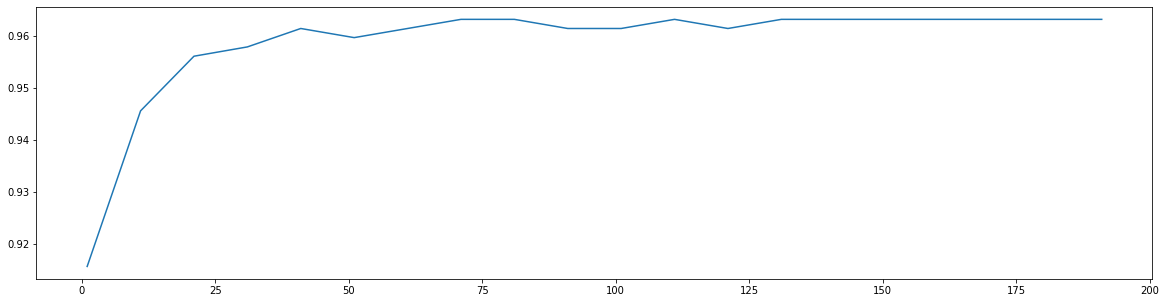

In [16]:
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),score1)
plt.show()

我们得为网格搜索做准备，所以，我们就得选一个范围，看看峰值在哪，我们看到峰值在71附近，于是我们就可以选[66-76]这个范围试试看

In [17]:
score2 = []
for i in range(66,77,1):
  rfc = RandomForestClassifier(n_estimators=i,random_state=90, n_jobs=-1)
  score = cross_val_score(rfc, X, y, cv=10).mean()
  score2.append(score)
print(max(score2))

0.9666353383458647


In [20]:
print(score2.index(max(score2))+66)

73


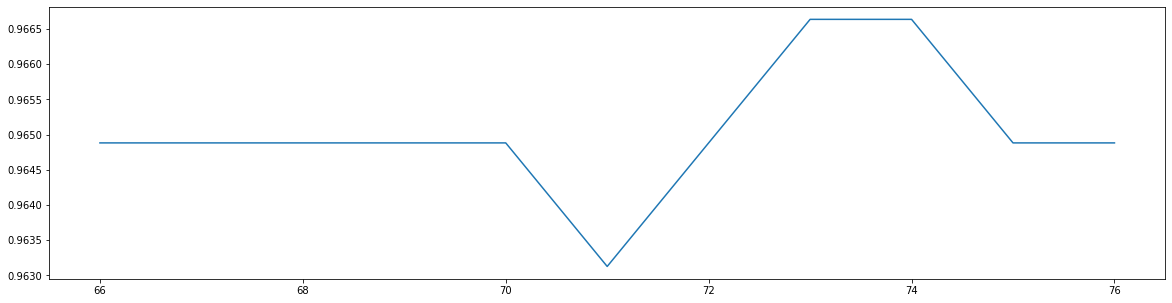

In [18]:
plt.figure(figsize=[20,5])
plt.plot(range(66,77,1),score2)
plt.show()

接下来我们试试max depth.我们可以用GridSearchCV来检查max depth参数

因为breast cancer的数据量比较小，而且features也不多，可以试试1-20层，如果数据量大，而且特征多的话，要试试30-50层，甚至更多

In [21]:
param_grid={'max_depth':np.arange(1,20,1)}

rfc = RandomForestClassifier(n_estimators=73,random_state=90)

GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(X,y)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=73, n_jobs=None,
                                              oob_score=False, random_state=90,
                                  

In [22]:
GS.best_params_

{'max_depth': 8}

In [23]:
GS.best_score_

0.9666353383458647

调整max_features

max_features是唯一一个即能够将模型往左（低方差高偏差）推，也能够将模型往右（高方差低偏差）推的参数。我们需要根据调参前，模型所在的位置（在泛化误差最低点的左边还是右边）来决定我们要将max_features往哪边调。现在模型位于图像左侧，我们需要的是更高的复杂度，因此我们应该把max_features往更大的方向调整，可用的特征越多，模型才会越复杂。max_features的默认最小值是sqrt(n_features)，因此我们使用这个值作为调参范围的最小值。


In [24]:
param_grid ={'max_features':np.arange(5,30,1)}

rfc = RandomForestClassifier(n_estimators=73,max_depth=8,random_state=90)
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(X,y)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=8,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=73, n_jobs=None,
                                              oob_score=False, random_state=90,
                                     

In [25]:
GS.best_params_

{'max_features': 22}

In [26]:
GS.best_score_

0.968421052631579

调整min_samples_leaf

In [30]:
param_grid ={'min_samples_leaf':np.arange(1,1+10,1)}

rfc = RandomForestClassifier(n_estimators=73,max_depth=8,max_features=22,random_state=90)
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(X,y)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=8,
                                              max_features=22,
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=73, n_jobs=None,
                                              oob_score=False, random_state=90,
                                         

In [31]:
GS.best_params_

{'min_samples_leaf': 1}

我们看见min_samples_leaf返回最小值，这说明，这基本已经达到了模型的边界了

In [32]:
GS.best_score_

0.968421052631579

调整min_samples_split

In [33]:
param_grid ={'min_samples_split':np.arange(2,2+10,1)}

rfc = RandomForestClassifier(n_estimators=73,max_depth=8,max_features=22,min_samples_leaf = 1,random_state=90)
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(X,y)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=8,
                                              max_features=22,
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=73, n_jobs=None,
                                              oob_score=False, random_state=90,
                                         

In [34]:
GS.best_params_

{'min_samples_split': 2}

In [35]:
GS.best_score_

0.968421052631579

最后我们再看看criterion的的区别

In [37]:
param_grid ={'criterion':['gini','entropy']}
rfc = RandomForestClassifier(n_estimators=73,max_depth=8,max_features=22,min_samples_leaf = 1,min_samples_split=2,random_state=90)
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(X,y)


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=8,
                                              max_features=22,
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=73, n_jobs=None,
                                              oob_score=False, random_state=90,
                                         

In [38]:
GS.best_params_

{'criterion': 'gini'}

In [39]:
GS.best_score_

0.968421052631579

总结，我们进行所有参数的调整，得出我们的精确度提升了那么一丢丢。这是sklearn自带的数据集，所以，我们可以用在这里学到的技巧在Titanic，或者在digital recognizor的数据集进行调参